# Invasive Ductal Carcinoma Breast Cancer Prediction Using Convolutional Neural Network  
2301878624 - Vincent Ciptadi  
2301893985 - Gabrielle Angelica  
2301854492 - Angelia

In [1]:
!pip install -q kaggle #connect kaggle to colab

In [2]:
from google.colab import files
files.upload() #upload kaggle API to colab

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"angeliaw","key":"b749996524accd53bf581aaee676fdb8"}'}

In [3]:
from google.colab import drive
drive.mount('/content/drive') #biar dataset yang di download masuk ke folder colab

Mounted at /content/drive


In [4]:
!mkdir ~/.kaggle # Make directory named kaggle
!cp kaggle.json ~/.kaggle/ # Copy kaggle.json file in kaggle directory

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images #dataset download

100% 3.09G/3.10G [00:51<00:00, 40.1MB/s]
100% 3.10G/3.10G [00:51<00:00, 64.1MB/s]


In [7]:
!unzip \*.zip

Streaming output truncated to the last 5000 lines.
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2251_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2301_class0.png  
  inflating: IDC_regular_

IMPORT LIBRARY YANG DIBUTUHKAN

In [8]:
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
import cv2
import sklearn
from sklearn.utils import class_weight
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline

Load data dan make sure data sudah ke load

In [9]:
imagePatches = glob('/content/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

/content/IDC_regular_ps50_idx5/10299/1/10299_idx5_x1401_y401_class1.png
/content/IDC_regular_ps50_idx5/10299/1/10299_idx5_x1801_y1301_class1.png
/content/IDC_regular_ps50_idx5/10299/1/10299_idx5_x701_y2051_class1.png
/content/IDC_regular_ps50_idx5/10299/1/10299_idx5_x1201_y251_class1.png
/content/IDC_regular_ps50_idx5/10299/1/10299_idx5_x2001_y1001_class1.png
/content/IDC_regular_ps50_idx5/10299/1/10299_idx5_x401_y1751_class1.png
/content/IDC_regular_ps50_idx5/10299/1/10299_idx5_x1601_y701_class1.png
/content/IDC_regular_ps50_idx5/10299/1/10299_idx5_x751_y1251_class1.png
/content/IDC_regular_ps50_idx5/10299/1/10299_idx5_x2001_y1801_class1.png
/content/IDC_regular_ps50_idx5/10299/1/10299_idx5_x1801_y2051_class1.png


Mengelompokkan foto berdasarkan class, seperti class0 artinya negatif, class1 artinya positif

In [10]:
class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in imagePatches:
    if filename.endswith("class0.png"):
        class0.append(filename)
    else:
        class1.append(filename)

print jumlah data di class masing-masing

In [11]:
print("Class 0 :", len(class0))
print("Class 1 :", len(class1))

Class 0 : 198738
Class 1 : 78786


plotting salah satu foto untuk class1

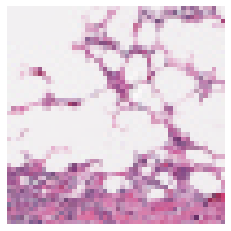

In [ ]:
image_name = "/content/IDC_regular_ps50_idx5/10269/1/10269_idx5_x1251_y1401_class1.png" #Image to be used as query
def plotImage(image_location):
    image = cv2.imread(image_name)
    image = cv2.resize(image, (50,50))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')
    return
plotImage(image_name)

print 25 foto

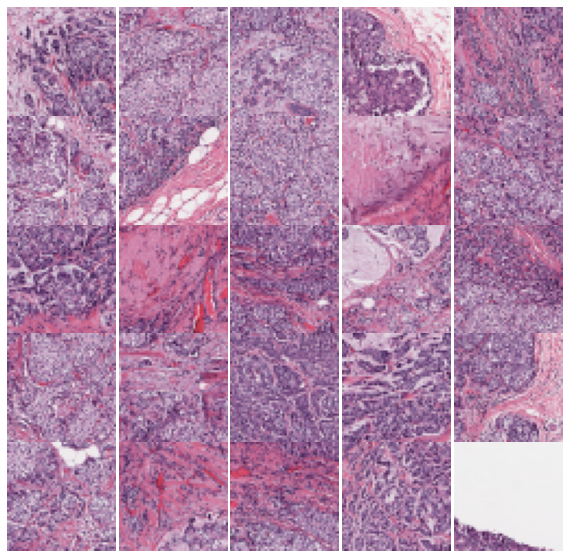

In [ ]:
bunchOfImages = imagePatches
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in bunchOfImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (50, 50)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

mengambil 3 foto random dari dataset

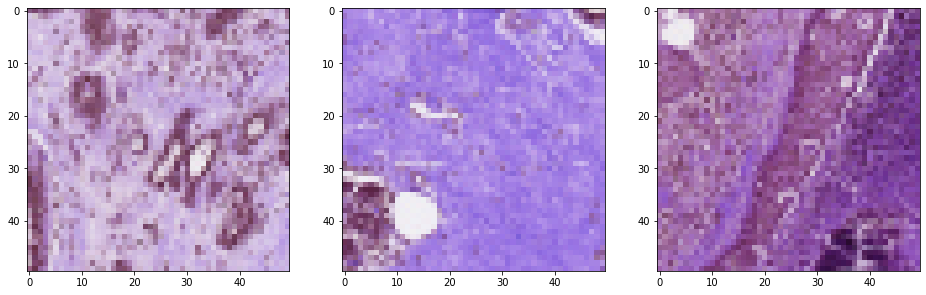

In [ ]:
def randomImages(a):
    r = random.sample(a, 4)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2])); 
randomImages(imagePatches)

Mengelompokkan file foto berdasarkan pattern nama class kedalam classZero (IDC(-)) dan classOne (IDC (+))
IDC -> Invasive Ductal Carcinoma (jenis kanker payudara pada dataset ini)  
...

In [12]:
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero)
classOne = fnmatch.filter(imagePatches, patternOne)
print("IDC(-)\n\n",classZero[0:5],'\n')
print("IDC(+)\n\n",classOne[0:5])

IDC(-)

 ['/content/IDC_regular_ps50_idx5/10299/0/10299_idx5_x1001_y2451_class0.png', '/content/IDC_regular_ps50_idx5/10299/0/10299_idx5_x701_y501_class0.png', '/content/IDC_regular_ps50_idx5/10299/0/10299_idx5_x101_y1351_class0.png', '/content/IDC_regular_ps50_idx5/10299/0/10299_idx5_x401_y2551_class0.png', '/content/IDC_regular_ps50_idx5/10299/0/10299_idx5_x351_y651_class0.png'] 

IDC(+)

 ['/content/IDC_regular_ps50_idx5/10299/1/10299_idx5_x1401_y401_class1.png', '/content/IDC_regular_ps50_idx5/10299/1/10299_idx5_x1801_y1301_class1.png', '/content/IDC_regular_ps50_idx5/10299/1/10299_idx5_x701_y2051_class1.png', '/content/IDC_regular_ps50_idx5/10299/1/10299_idx5_x1201_y251_class1.png', '/content/IDC_regular_ps50_idx5/10299/1/10299_idx5_x2001_y1001_class1.png']


Preprocess foto menjadi ukuran 50x50 dan melakukan mapping foto berdasarkan label

In [13]:
def proc_images(lowerIndex,upperIndex): # x = image, y = label
    x = []
    y = []
    WIDTH = 50
    HEIGHT = 50
    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

Mengambil dan memproses mapping 40000 foto yang mengereturn x = foto yang size nya sudah diperkecil, y = label class

In [14]:
X,Y = proc_images(0,40000)
df = pd.DataFrame()
df["images"]=X
df["labels"]=Y
X2=df["images"]
Y2=df["labels"]
X2=np.array(X2)
imgs0=[]
imgs1=[]
imgs0 = X2[Y2==0] # (0 = no IDC, 1 = IDC)
imgs1 = X2[Y2==1] 

In [ ]:
# data_x = np.array(data_x)

print hasil pengolahan data

In [15]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X2,Y2)

Total number of images: 40000
Number of IDC(-) Images: 29261
Number of IDC(+) Images: 10739
Percentage of positive images: 26.85%
Image shape (Width, Height, Channels): (50, 50, 3)


print dataframe dari dataset

In [16]:
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
print(df.head(10))
print("")
print(dict_characters)

                                              images  labels
0  [[[137, 81, 149], [152, 97, 173], [155, 100, 1...       1
1  [[[140, 84, 127], [181, 147, 177], [189, 155, ...       1
2  [[[149, 96, 185], [163, 118, 199], [130, 78, 1...       1
3  [[[233, 227, 235], [239, 235, 239], [241, 233,...       1
4  [[[132, 75, 121], [201, 186, 212], [159, 107, ...       1
5  [[[144, 101, 150], [178, 137, 174], [166, 118,...       1
6  [[[215, 192, 208], [180, 148, 181], [221, 205,...       1
7  [[[182, 145, 192], [191, 155, 192], [130, 77, ...       1
8  [[[140, 78, 136], [123, 75, 118], [204, 180, 2...       1
9  [[[157, 105, 166], [131, 71, 114], [143, 89, 1...       1

{0: 'IDC(-)', 1: 'IDC(+)'}


Menampilkan satu foto yang negatif kanker dan satu foto positif kanker

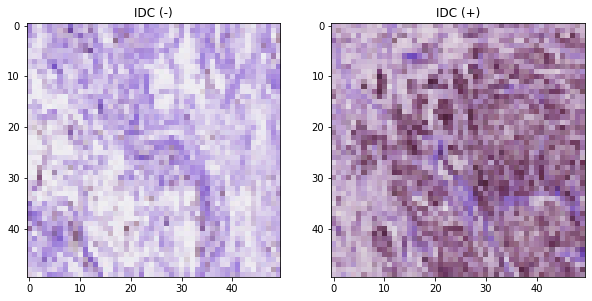

In [ ]:
def plotOne(a,b):
    """
    Plot one numpy array
    """
    plt.subplot(1,2,1)
    plt.title('IDC (-)')
    plt.imshow(a[0])
    plt.subplot(1,2,2)
    plt.title('IDC (+)')
    plt.imshow(b[0])
plotOne(imgs0, imgs1) 

plotting 3 gambar negatif dan 3 gambar positif

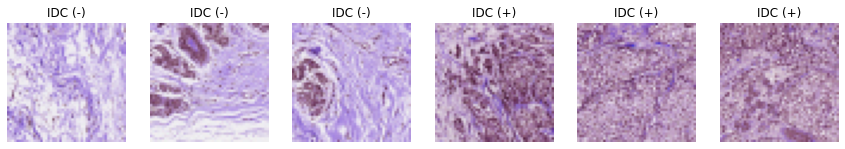

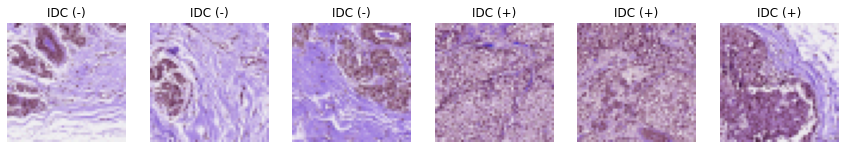

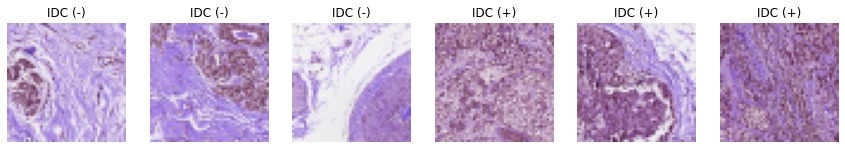

In [ ]:
def plotTwo(a,b): 
    """
    Plot a bunch of numpy arrays sorted by label
    """
    for row in range(3):
        plt.figure(figsize=(20, 10))
        for col in range(3):
            plt.subplot(1,8,col+1)
            plt.title('IDC (-)')
            plt.imshow(a[0+row+col])
            plt.axis('off')       
            plt.subplot(1,8,col+4)
            plt.title('IDC (+)')
            plt.imshow(b[0+row+col])
            plt.axis('off')
plotTwo(imgs0, imgs1)

plot histogram dari foto ke 100

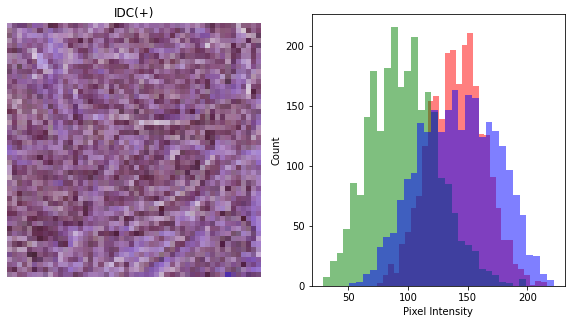

In [ ]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    plt.title('IDC(+)' if Y[1] else 'IDC(-)')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X2[100])

ukuran datanya dari 0 sampai 256, mau diubah menjadi 0 sampai 1
Melakukan train test split dengan test 20% train 80%

In [17]:
X=np.array(X)
X=X/255.0

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Reduce Sample Size for DeBugging
X_train = X_train[0:300000] 
Y_train = Y_train[0:300000]
X_test = X_test[0:300000] 
Y_test = Y_test[0:300000]

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (32000, 50, 50, 3)
Testing Data Shape: (8000, 50, 50, 3)


plot training foto ke 101

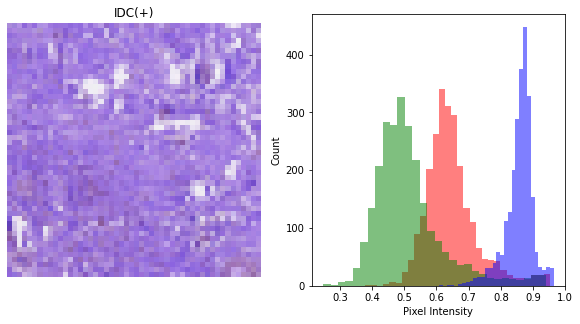

In [ ]:
plotHistogram(X_train[100])

Mengubah bentuk label menjadi categorical berjumlah 2 class dengan value 0 dan 1

In [18]:
Y_trainHot = to_categorical(Y_train, num_classes = 2)
Y_testHot = to_categorical(Y_test, num_classes = 2)

plotting jumlah data yang memiliki value 0 dan 1

0    29261
1    10739
Name: labels, dtype: int64
{0: 'IDC(-)', 1: 'IDC(+)'}


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


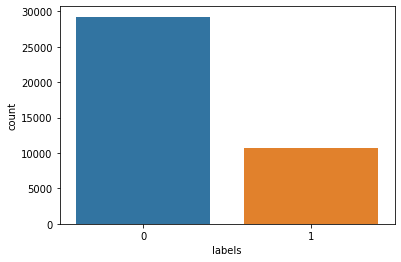

In [19]:
lab = df['labels']
dist = lab.value_counts()
print(dist)
sns.countplot(lab)
print(dict_characters)

Mengatasi ukuran class yang tidak seimbang

Mengambil sample dari class yang sudah di reshape

Mengonversi variable y menjadi tipe categorical

Melakukan reshape pada variable X dan plotting hasil dari penyetaraan jumlah data tiap class

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

{0: 'IDC(-)', 1: 'IDC(+)'}


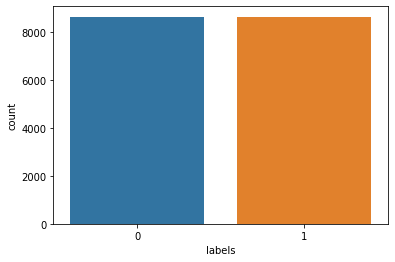

In [20]:
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)

from imblearn.under_sampling import RandomUnderSampler

ros = RandomUnderSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)

Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 2)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 2)

for i in range(len(X_trainRos)):
    height, width, channels = 50,50,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)

for i in range(len(X_testRos)):
    height, width, channels = 50,50,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
  
dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = labRos.value_counts()
sns.countplot(labRos)
print(dict_characters)

In [21]:
print(distRos)

1    8641
0    8641
Name: labels, dtype: int64


Melihat perbandingan weight class sebelum dan sesudah di reshape

In [22]:
classweight = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
class_weight_dict = dict(enumerate(classweight))
print("Old Class Weights: ",class_weight_dict)
classweight2 = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
class_weight2_dict = dict(enumerate(classweight2))
print("New Class Weights: ",class_weight2_dict)

Old Class Weights:  {0: 0.6849608288026029, 1: 1.851637541951163}
New Class Weights:  {0: 1.0, 1: 1.0}


In [23]:
# Checkpoint, plot learning curve dan confusion matrix
class MetricsCheckpoint(Callback):
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve(checkpoint):
    plt.figure(figsize=(10,5))
    metrics = np.load(checkpoint, allow_pickle=True)[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [24]:
def runKerasCNNAugment(a, b, c, d, e, f, optimizer, size, epochs, save_name):
    num_classes = 2
    img_rows, img_cols = a.shape[1],a.shape[2]
    input_shape = (img_rows, img_cols, 3)
    callback = EarlyStopping(monitor='loss', patience=3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    print(model.summary())
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit(datagen.flow(a,b, batch_size=size),
                        steps_per_epoch=len(a) / size, 
                        epochs=epochs, 
                        class_weight=f,
                        callbacks=[callback, MetricsCheckpoint(save_name)],
                        validation_data = (c, d))
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1)
    
    plotKerasLearningCurve(save_name+'.npy')
    plt.show()
    plot_learning_curve(history)
    plt.show()
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               991360    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

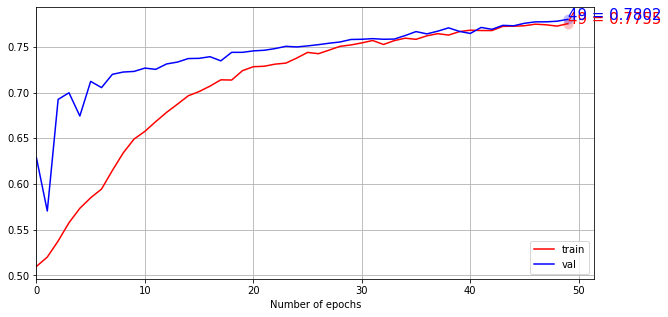

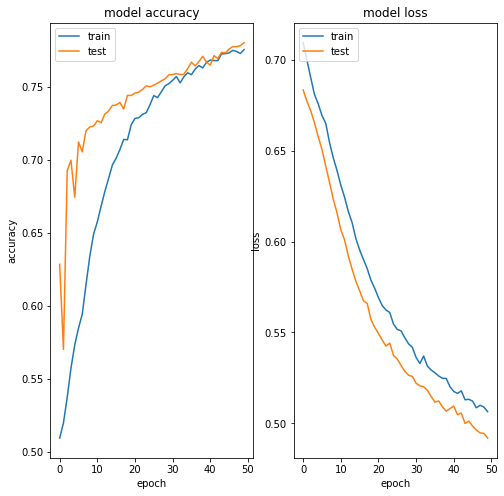

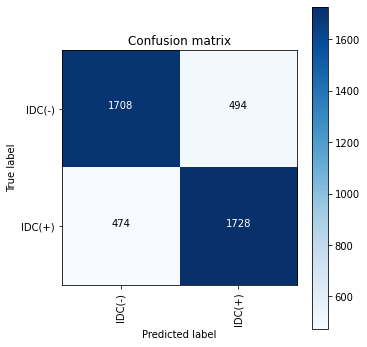

In [ ]:
runKerasCNNAugment(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2_dict, keras.optimizers.Adadelta(), 32, 50, 'type1')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 32)        896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               991360    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

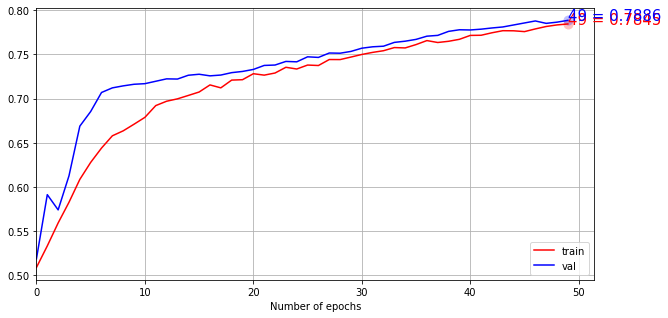

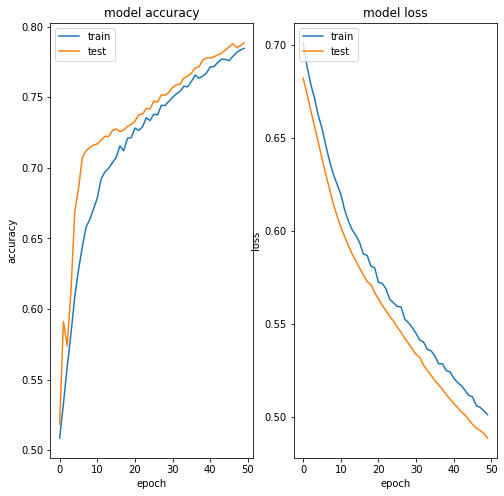

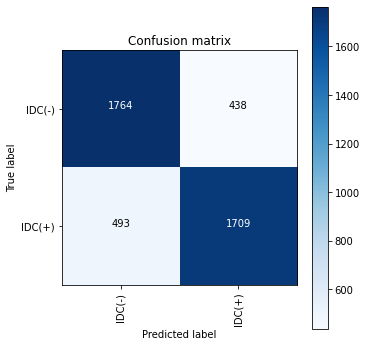

In [ ]:
runKerasCNNAugment(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2_dict, keras.optimizers.Adadelta(), 16, 50, 'type2')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               991360    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

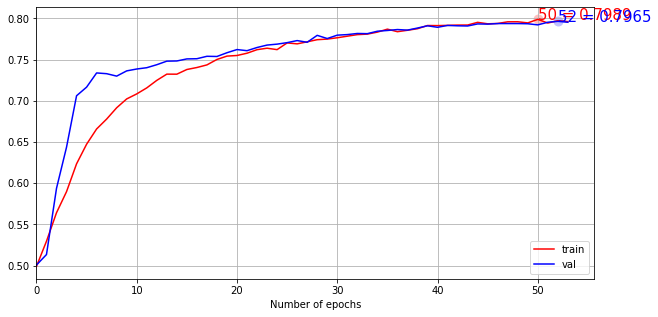

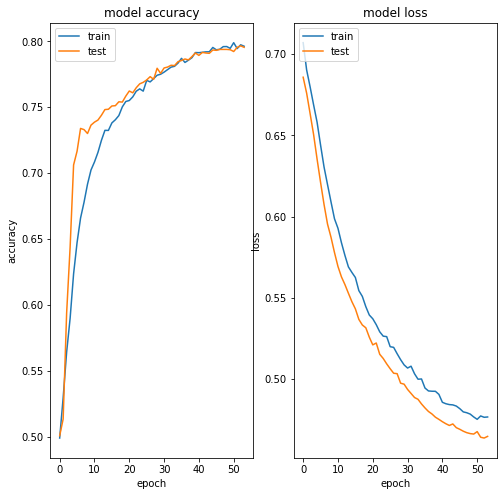

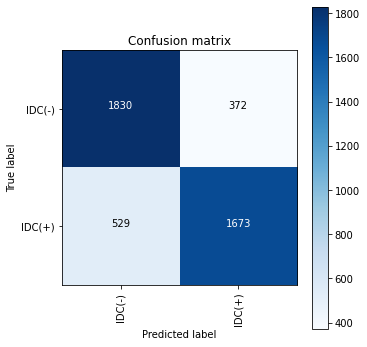

In [ ]:
runKerasCNNAugment(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2_dict, keras.optimizers.Adadelta(), 10, 100, 'type3')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 24, 24, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               991360    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)              

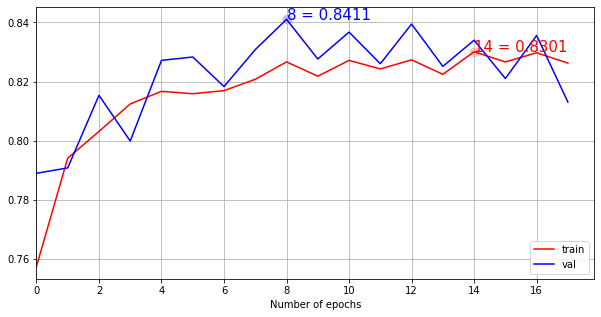

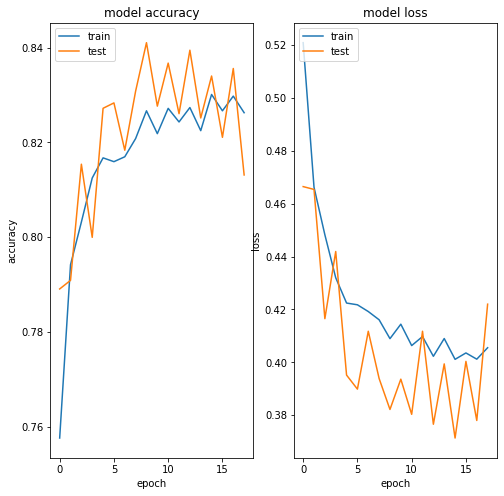

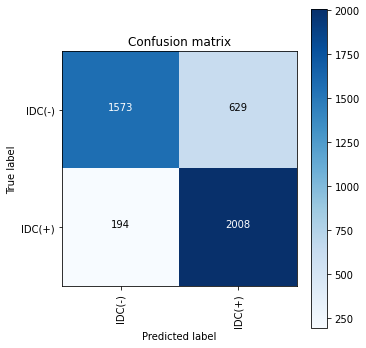

In [ ]:
runKerasCNNAugment(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2_dict, keras.optimizers.Adam(), 10, 100, 'type4')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 32)        896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               991360    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


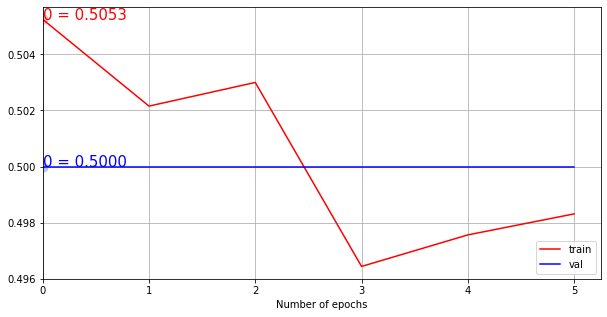

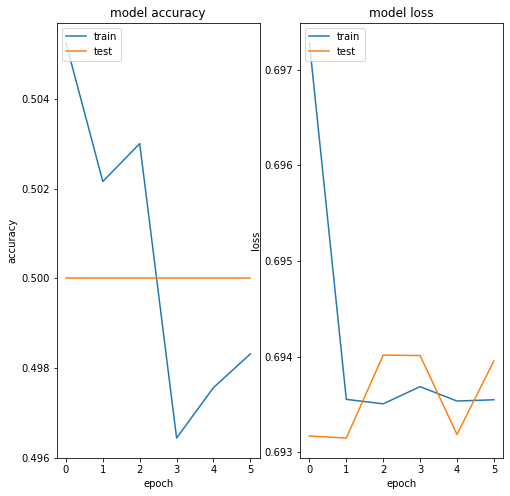

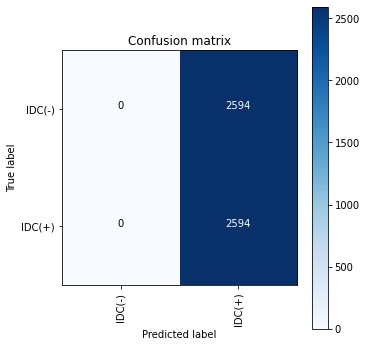

In [ ]:
runKerasCNNAugment(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2_dict, keras.optimizers.Adam(learning_rate=0.005), 10, 100, 'type5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               991360    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

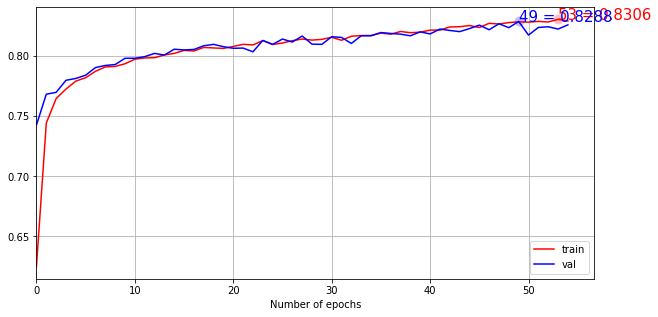

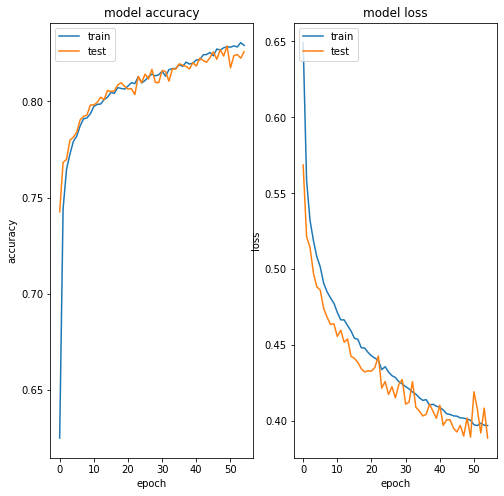

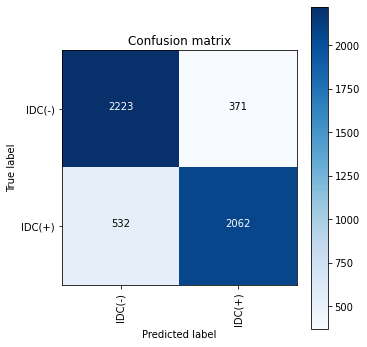

In [ ]:
runKerasCNNAugment(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2_dict, keras.optimizers.Adadelta(learning_rate=0.005), 10, 100, 'type6')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               991360    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

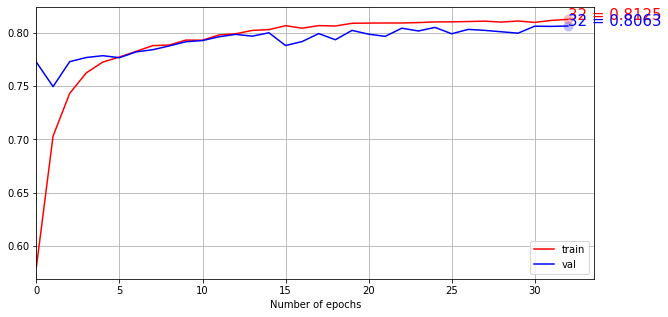

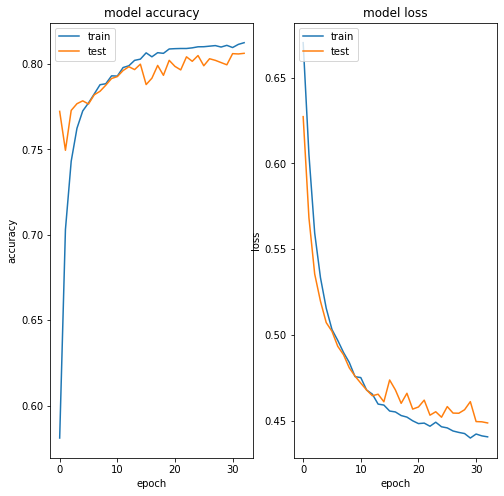

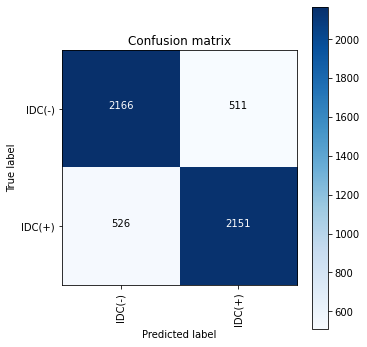

In [ ]:
runKerasCNNAugment(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2_dict, keras.optimizers.Adadelta(learning_rate=0.003), 10, 500, 'type7')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               991360    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

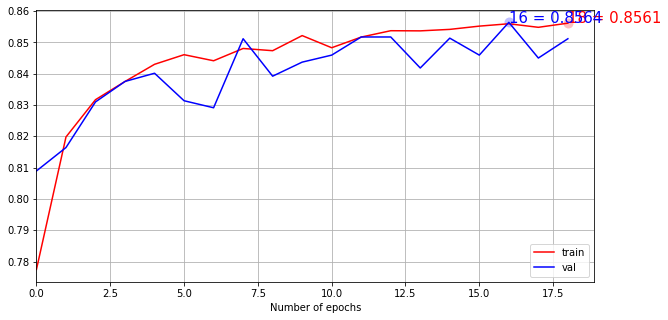

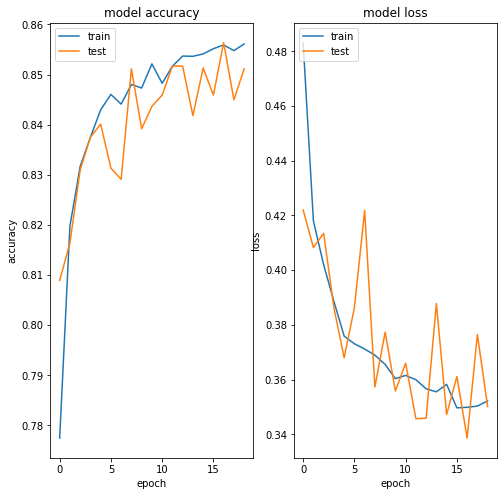

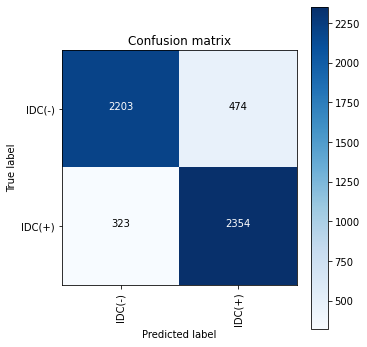

In [ ]:
runKerasCNNAugment(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2_dict, keras.optimizers.Adam(learning_rate=0.0007), 10, 500, 'type8')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               991360    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

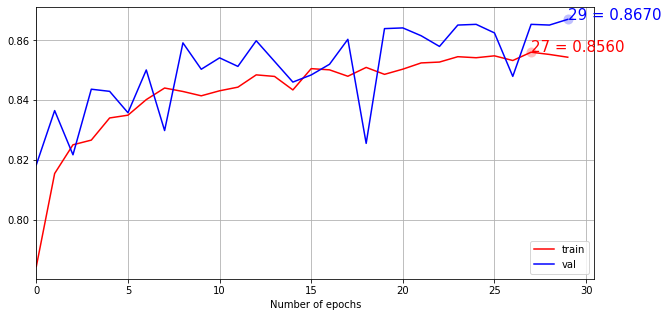

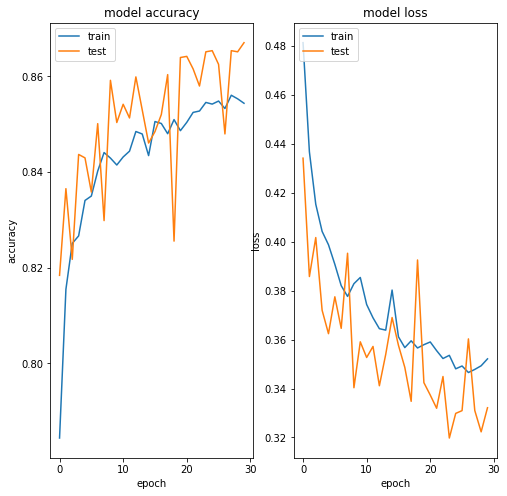

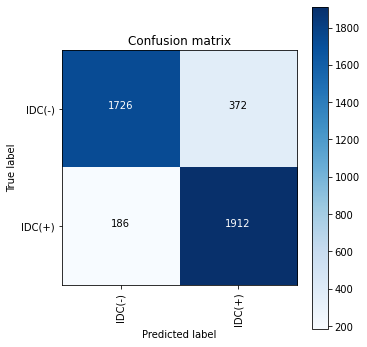

In [25]:
runKerasCNNAugment(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2_dict, keras.optimizers.Adam(learning_rate=0.0005), 10, 500, 'type9')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 32)        896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               991360    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

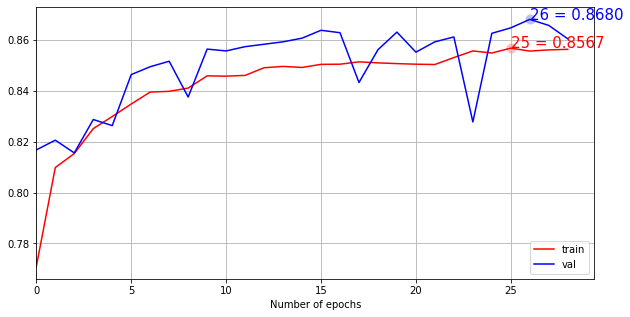

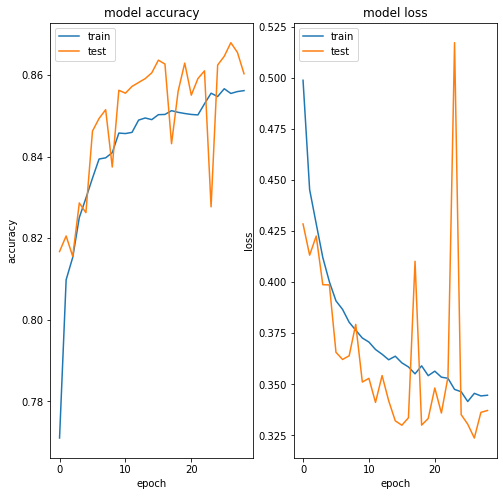

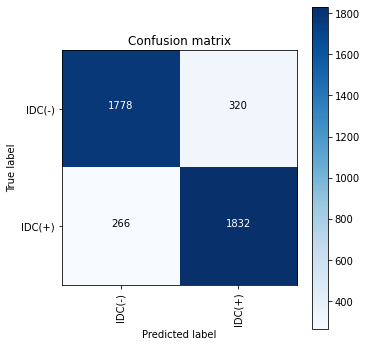

In [26]:
runKerasCNNAugment(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2_dict, keras.optimizers.Adam(learning_rate=0.0003), 10, 500, 'type10')